<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/fr/thumb/e/e5/Logo_%C3%A9cole_des_ponts_paristech.svg/676px-Logo_%C3%A9cole_des_ponts_paristech.svg.png" width="200"  height="200" hspace="200"/> </td>
<td> <img src="https://pbs.twimg.com/profile_images/1156541928193896448/5ihYIbCQ_200x200.png" width="200" height="200" /> </td>
</tr></table>

<br/>

<h1><center>Advanced Modelling</center></h1>



<font size="3">This session is divided into **2** main parts:
- **1 - Classification example adapted to computer vision (Handwritten digit recognition)**
- **2 - Regression example adapted to IMDB data**

In each of these parts, some **guidelines** and **hints** are given for each task. 
Do not hesitate to check the links to documentation to understand the functions you use. 
    
The goal of this session is for you to **be able to create a deep learning model for a regression purpose** (predicting french movies sales). We will use a **classification example adapted to computer vision first** in order for you to be familiar with the Deep Learning processes and we will try to replicate the word and create a fully connected network for our regression problem. All the work is based on **pytorch** and the computer vision example (MNIST) is inspired by a tutorial done by the fastai team.
</font>

# 1. Classification on MNIST dataset (handwritten digit recognition)
#### *NB: Nothing to fill, just run the cells for this part*

## 1.1 Loading the MNIST dataset from pytorch

In [1]:
from pathlib import Path
import requests
import pickle
import gzip

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
### The dataset comes already with a training, a validation and a test sets. We will use them as is.
### The data is stored as numpy array

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

## 1.2 Data visualization 

In [4]:
from matplotlib import pyplot
import numpy as np

(50000, 784)


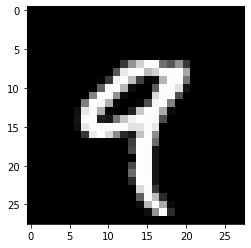

In [5]:
### Let's visualize an image 
pyplot.imshow(x_train[4].reshape((28, 28)), cmap="gray")
print(x_train.shape)

## 1.3 Modeling

### 1.3.1 Tensors

!pip install torch

In [6]:
import torch

In [7]:
### Before we proceed, we will transform the numpy to tensor as it is easier to work with for deep learning
### [TO DO YAGUE]: explain tensor principle
x_train, y_train, x_valid, y_valid, x_test, y_test = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test)
)

In [8]:
### Lets build a dataset using the TensorDataset of pytorch library
### A dataset object is a convenient way to have x (features, here the image) and y (the label, which digit is it) 
### at the same time

from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test, y_test)

### 1.3.2 DataLoader

In [9]:
### A dataloader is also convenient object for deep learning as we can iterate the dataset by batch
### All you have to do is pick a batch size and by iterationg over the dataloader, you will receive batch of your dataset

from torch.utils.data import DataLoader

bs= 64
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)
test_dl = DataLoader(test_ds, batch_size=bs*2)

### 1.3.3 Model

In [10]:
from torch import nn

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [11]:
### NN.Sequential allows us to easily stack layers to build an network of convolutionnal layers. It is usefull
### here because we are dealing with images
### The first layer (Lambda) is just here to transform the vector into a 28x28 pixel square image
### ReLu is an activation function (more info in the appendix of the session 8 presentation)
### AvgPool2d is an Average pooling layer (more info in the appendix of the session 8 presentation)

# We initialize the model with the previously mentioned layers
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

In [12]:
from torch import optim

### We define the parameters of the network:

### Choose a learning rate
lr = 0.1

### Define an optimizer to run our gradient descent algorithm. We choose a stochastic gradient descent (SGD). 
### NB: Momentum helps the training go faster but it is optional
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [13]:
import torch.nn.functional as F

### Let's define the loss function.
### We pick the cross entropy loss as we are facing a classification problem
loss_func = F.cross_entropy

In [14]:
import numpy as np

# We define a function to compute the loss for a batch (i.e. a sample) of data
def loss_batch(model, loss_func, xb, yb, opt=None):
    ''' Will compute the loss for a batch and the gradient if opt is given'''
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

# We define a function to fit (i.e. train) the model on our data (train and valid datasets)
# Different parameters must be precised: 
# - epochs (number of training iterations to do), 
# - model (neural network architecture), 
# - loss_func (loss function), 
# - opt (optimizer), 
# - train_dl (training dataset, dataloader object), 
# - valid_dl (validation dataset, dataloader object)
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # We train the model
        model.train()
        # We iterate on the training data per batch
        for xb, yb in train_dl:
            # We compute the loss on each batch
            loss_batch(model, loss_func, xb, yb, opt)
        # We evaluate the model
        model.eval()
        with torch.no_grad():
            # We compute the loss per batch
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # We sum up the losses for the entire validation set
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # We print the loss for each epoch
        print(epoch, val_loss)


In [15]:
### Choose a number of epochs for training (less than 50 otherwise it will take a long time to run)
epochs= 20

In [16]:
### Call the 'fit' function to train the model using the dataloaders for train and valid and it will print the 
### loss for the validation set
import time
start_time = time.time()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)
print("--- %s minutes ---" % np.round((time.time() - start_time)/60, 2))

0 0.30515610204935073
1 0.2977557823181152
2 0.21001164155006408
3 0.20034705535173417
4 0.15707349194288253
5 0.14662755954265594
6 0.14445211496055127
7 0.13919810348749162
8 0.13430282634794713
9 0.13992671927511693
10 0.11888606450706721
11 0.12575418030023575
12 0.13745020753741263
13 0.15738906062841415
14 0.12075926521718502
15 0.11851345114260912
16 0.1229674611479044
17 0.1266410844348371
18 0.14309599875733256
19 0.11794129944294691
--- 3.25 minutes ---


### 1.3.4 Prediction and evaluation

In [17]:
### We make predictions on the validation set
model.eval()
predictions = model(x_test)

In [18]:
### We compute the accuracy of the classifier. 
### This is the metric that tells us how good we can recognize handwritten digits
(torch.argmax(predictions, dim = 1) == y_test).float().mean()

tensor(0.9652)

# 2. Regression on IMDB data (predicting french movies sales)
#### *NB: This part has some cells that need to be filled*

In [1]:
import torch
torch.manual_seed(0)

## 2.1 Loading the IMDB dataset as in previous sessions

In [2]:
import pandas as pd
import torch

# Loading data
def load_dataset(path):
    print(f"loading raw data..")
    data = pd.read_csv(path)
    data.drop(['title'], axis = 1, inplace = True)
    return data

# Cleaning data (remove 2020 year, ...)
def clean_data(data, drop_2020=True):
    print(f"cleaning data..")
    data = data.dropna()
    if drop_2020:
        data = data.query("year != 2020")
    data = data.sort_values(by='release_date')
    data.release_date = pd.to_datetime(data.release_date)
    data.index = data.release_date
    data = data.drop(columns = ['index', 'release_date', 'year'], errors='ignore')
    return data

# Split dataset in train, validation and test sets by date (not randomly because it is a time series)
def train_test_split_by_date(df: pd.DataFrame, split_date_val: str, split_date_test: str):
    """Split dataset according to a split date in format "YYYY-MM-DD"
    - train: [:split_date_1[
    - validation: [split_date_1: split_date_2[
    - test: [split_date_2:[
    """
    train = df.loc[:split_date_val].copy()
    validation = df.loc[split_date_val:split_date_test].copy()
    test = df.loc[split_date_test:].copy()
    return train, validation, test

# Get the explanatory variables (features) and the target variable
def get_x_y(dataset):
    target = dataset.sales
    target = target.astype(float)
    features = dataset.drop(columns = ['sales'], errors='ignore')
    return features, target

In [3]:
# Update the path below with your own path to the dataset 'data_prepared_session4.csv' on your laptop:
#path = '/Users/yaguethiam/Ponts/data_prepared_session4.csv'
path = '../session4/data_prepared_session4.csv'

# Load the dataset
raw_data = load_dataset(path)
# Clean the dataset
data = clean_data(raw_data, drop_2020=False)
# Split into train, validation and test sets
train_data, validation_data, test_data = train_test_split_by_date(data,
                                                                  '2018-01-01',
                                                                  '2020-01-01')
# Get features and target on each dataset
train_x, train_y = get_x_y(train_data)
validation_x, validation_y = get_x_y(validation_data)
test_x, test_y = get_x_y(test_data)

loading raw data..
cleaning data..


## 2.2 Model

### 2.2.1 Data preparation (transform into tensors then dataloader)

In [7]:
from torch.utils.data import TensorDataset

### Create a TensorDataset for train and validation 
### /!\ Don't forget to take the logarithm of the target variable y 
### Convert the torch to float 

x_train  = torch.tensor(train_x.values).float()
x_valid  = torch.tensor(validation_x.values).float()
x_test   = torch.tensor(test_x.values).float()

y_train = torch.tensor(train_y.values).log().unsqueeze(1).float()
y_valid = torch.tensor(validation_y.values).log().unsqueeze(1).float()
y_test  = torch.tensor(test_y.values).log().unsqueeze(1).float()

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test, y_test)

In [8]:
from torch.utils.data import DataLoader

### Create a Dataloader from the tensors
### Choose a batch size 
### Hint: 500 is a good choice but feel free to change it

bs = 500
train_dl = DataLoader(train_ds, batch_size = bs, shuffle = False)
valid_dl = DataLoader(valid_ds, batch_size = bs)
test_dl = DataLoader(test_ds, batch_size = bs)

### 2.2.2 Model definition

In [4]:
from torch import nn

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [9]:
### Define the number of input features into the variable 'm'
m = x_train.shape[1]

### Choose a number of hidden layers
nh = 600

### Choose a value for the dropout probability. 
### Hint: 0.15 is a good choice
dropout = 0.15

In [10]:
### Compute the mean and the standard deviation of the training data
### Why do we only compute the mean and standard deviation of the training data for the normalization to come?
### [TO DO YAGUE]: answer?

train_mean, train_std = x_train.mean(), x_train.std()

def normalize(x, m=train_mean, s=train_std):
    '''
    Normalize a dataset x with the mean (m) and the std dev (s)
    '''
    return (x - m) / s

In [11]:
### Build a sequential model using several layers in the right order:
### - Lambda (defined above, use the appropriate function in input, remember we want to normalize before 
###   anything happens)
### - nn.Linear
### - nn.Dropout (used for regularization)
### - nn.ReLu (used to build a non-linear model)
### - nn.Linear (output layer: should be of 1 dimension as we are doing a regression)
### Organize these layers correctly below. 

model = nn.Sequential(
    Lambda(normalize),
    nn.Linear(m,nh),
    nn.Dropout(dropout),
    nn.ReLU(),
    nn.Linear(nh,1)
)

In [12]:
### Choose an optimizer which uses gradient descent
### Give your optimizer the right parameters
### Optional: add momentum to it (it will help accelarate training, set it to 0.9 for example)

from torch import optim

lr = 0.2   # learning rate
momentum = 0.9
opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum) # optimizer

In [13]:
### Choose a number of epochs. The goal here is a number of epoch enough for your model to train and to not 
### overfit. You can try many values (not more than 100 if you want the training to be "fast")

epochs = 45 # how many epochs to train for

### Choose a loss function, remember what we did in the last session (it will not be the same but you can 
### choose one that will be very similar)
### Hint: for example L1Loss() but other loss are availabe, check the documentation for more info: 
### https://pytorch.org/docs/stable/nn.html#loss-functions
loss_func = nn.L1Loss()

### 2.2.3 Model training

In [14]:
import numpy as np

# We define a function to compute the loss for a batch (i.e. a sample) of data
def loss_batch(model, loss_func, xb, yb, opt=None):
    ''' Will compute the loss for a batch and the gradient if opt is given'''
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb)

# We define a function to fit (i.e. train) the model on our data (train and valid datasets)
# Different parameters must be precised: 
# - epochs (number of training iterations to do), 
# - model (neural network architecture), 
# - loss_func (loss function), 
# - opt (optimizer), 
# - train_dl (training dataset, dataloader object), 
# - valid_dl (validation dataset, dataloader object)
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # We train the model
        model.train()
        # We iterate on the training data per batch
        for xb, yb in train_dl:
            # We compute the loss on each batch
            loss_batch(model, loss_func, xb, yb, opt)
        # We evaluate the model
        model.eval()
        with torch.no_grad():
            # We compute the loss per batch
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        # We sum up the losses for the entire validation set
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # We print the loss for each epoch
        print(epoch, val_loss)


In [15]:
### Call the 'fit' function to train your model
import time
start_time = time.time()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)
print("--- %s seconds ---" % (time.time() - start_time))

0 4.593199077405427
1 1.605095298666703
2 1.2365806761540865
3 1.1886418806879144
4 1.2277353625548513
5 1.1895310470932408
6 1.1821189679597552
7 1.2088692125521208
8 1.1758493341897662
9 1.1959153037322194
10 1.1873749682777806
11 1.1863461795606112
12 1.18363524738111
13 1.1899676605274803
14 1.178733389628561
15 1.1935930408929523
16 1.196315834396764
17 1.1890352587950856
18 1.18516827257056
19 1.183755055854195
20 1.1880590005924827
21 1.1775811314582825
22 1.186477607802341
23 1.1863717687757391
24 1.1948193311691284
25 1.178001996717955
26 1.1775296424564563
27 1.184769818657323
28 1.1667539696944387
29 1.1837405970222072
30 1.1776097448248612
31 1.1856837649094432
32 1.1816329077670449
33 1.1886571928074485
34 1.2070227328099703
35 1.186454923529374
36 1.1783447987154911
37 1.1789093143061589
38 1.233493237118972
39 1.193886769445319
40 1.1786415388709621
41 1.2002847100559033
42 1.2694188575995595
43 1.335924390115236
44 1.3213552330669605
--- 6.831168174743652 seconds ---


In [16]:
### Compute the loss function on the validation set
loss_func(model(x_valid), y_valid)

tensor(1.3214, grad_fn=<L1LossBackward>)

### 2.2.4 Predictions and evaluation

In [17]:
import numpy as np

In [18]:
def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [19]:
### Compute the new MAPE on the validation set
mean_absolute_percentage_error(model(x_test).exp().detach().numpy(), y_test.exp().detach().numpy())

### In comparison with what we obtained with classic algorithms in previous sessions, we can see that the MAPE
### is better with DL models, even a very simple one.

113.24774026870728